<a href="https://www.kaggle.com/code/meantaek/binary-classification-bank-churn?scriptVersionId=161490635" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e1/sample_submission.csv
/kaggle/input/playground-series-s4e1/train.csv
/kaggle/input/playground-series-s4e1/test.csv


In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')


# Exploratory Analysis

In [3]:
#Run summary statistics and initial exploration
df_train.describe()
#check for edge cases such as id's being 0 and check for nulls
df_train.loc[df_train['id'] == 0]
null_mask = df_train.isnull().any(axis=1)
null_rows = df_train[null_mask]
null_rows
#check for duplicates
df_train.duplicated().sum()
df_test.duplicated().sum()

0

# Graphs for each variable

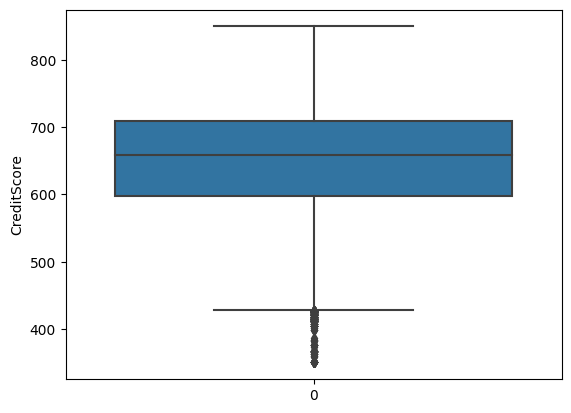

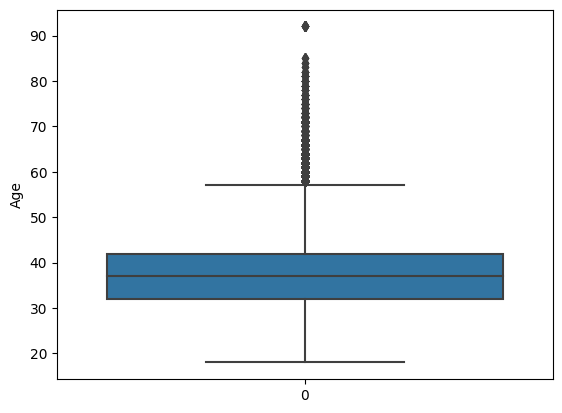

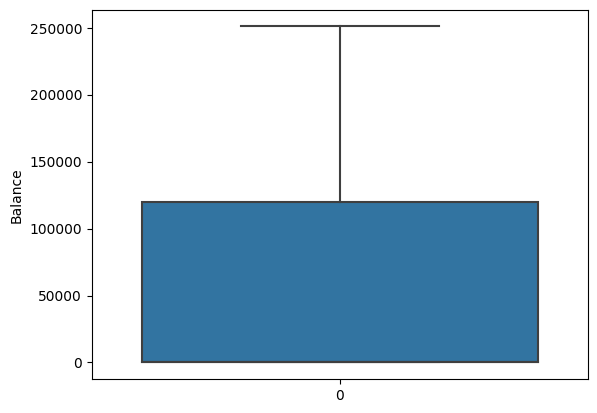

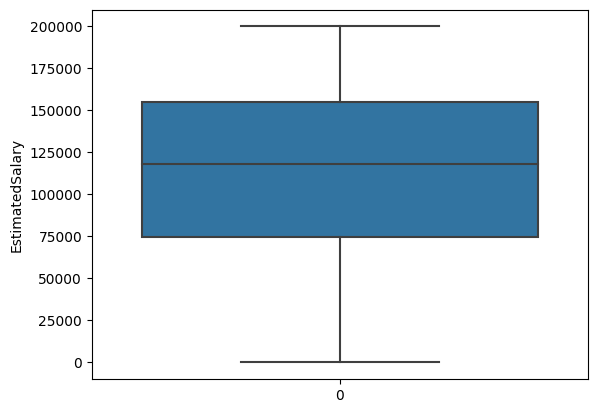

In [4]:
#numeric plots
numerical_variables = ['CreditScore','Age', 'Balance','EstimatedSalary' ]
for cols in numerical_variables:
    sns.boxplot(data=df_train[cols])
    plt.ylabel(cols)
    plt.show()

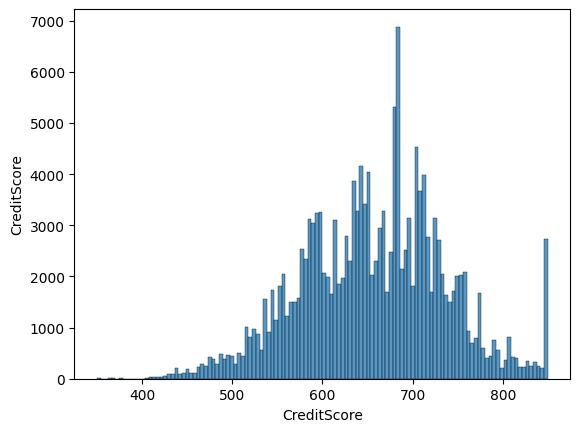

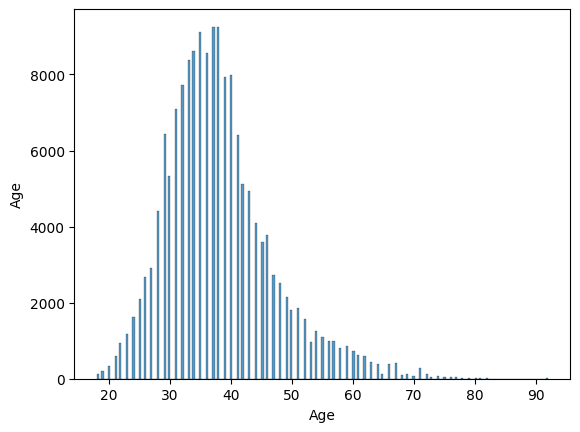

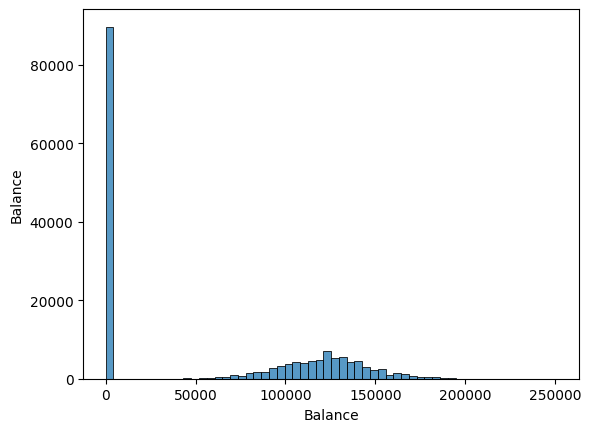

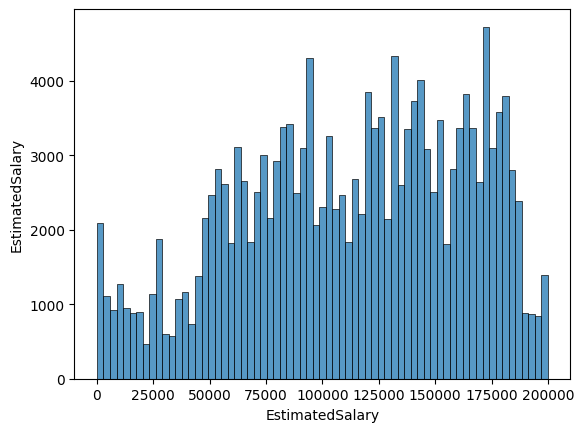

In [5]:
for cols in numerical_variables:
    sns.histplot(data=df_train[cols])
    plt.ylabel(cols)
    plt.show()

In [6]:
#print(df_train.head)

# Preprocessing Before Correlation Analysis

In [7]:
#after exploratory analysis, change balance into 0 vs non 0
def zerobalance(val):
    if val == 0:
        return 1
    else:
        return 0

df_train['ZeroBalance'] = df_train['Balance'].apply(zerobalance)
df_test['ZeroBalance'] = df_test['Balance'].apply(zerobalance)

#separate out columns for model building and 

label_encoder = preprocessing.LabelEncoder() 
df_train['Geography'] = label_encoder.fit_transform(df_train['Geography'])
df_train['Gender'] = label_encoder.fit_transform(df_train['Gender'])
df_test['Geography'] = label_encoder.fit_transform(df_test['Geography'])
df_test['Gender'] = label_encoder.fit_transform(df_test['Gender'])

X = df_train[['CreditScore', 'Geography','Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'ZeroBalance']]
y = df_train["Exited"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

df_test_m = df_test[['CreditScore', 'Geography','Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'ZeroBalance']]

# Correlation Analysis

In [8]:
corr = df_train[['CreditScore', 'Geography','Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'ZeroBalance', 'Exited']].corr()
corr.style.background_gradient(cmap='coolwarm')

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,ZeroBalance,Exited
CreditScore,1.000000,0.005379,0.002310,-0.008918,0.000942,0.006973,0.011361,-0.002828,0.014790,-0.001820,-0.007843,-0.027383
Geography,0.005379,1.000000,-0.012092,0.034110,0.000276,0.134642,-0.025123,-0.016715,-0.003493,-0.004102,-0.139936,0.053343
Gender,0.002310,-0.012092,1.000000,-0.063139,0.008767,-0.014699,0.026098,0.006418,0.033722,-0.007778,0.016267,-0.146442
Age,-0.008918,0.034110,-0.063139,1.000000,-0.010830,0.064318,-0.102195,-0.012111,0.003320,-0.005399,-0.065862,0.340768
Tenure,0.000942,0.000276,0.008767,-0.010830,1.000000,-0.009481,0.007335,0.005327,-0.005532,0.000971,0.010969,-0.019565
Balance,0.006973,0.134642,-0.014699,0.064318,-0.009481,1.000000,-0.361033,-0.018584,-0.015073,0.008586,-0.963088,0.129743
NumOfProducts,0.011361,-0.025123,0.026098,-0.102195,0.007335,-0.361033,1.000000,0.005482,0.039736,-0.004285,0.372232,-0.214554
HasCrCard,-0.002828,-0.016715,0.006418,-0.012111,0.005327,-0.018584,0.005482,1.000000,-0.021034,0.004438,0.021311,-0.022141
IsActiveMember,0.014790,-0.003493,0.033722,0.003320,-0.005532,-0.015073,0.039736,-0.021034,1.000000,-0.008080,0.015276,-0.210237
EstimatedSalary,-0.001820,-0.004102,-0.007778,-0.005399,0.000971,0.008586,-0.004285,0.004438,-0.008080,1.000000,-0.008225,0.018827


In [9]:
#bivariate analysis
bivariate = add_constant(X)
for cols in X.columns:
    bivariate = bivariate[~pd.isnull(bivariate[cols])]
vif = pd.DataFrame()
vif["feature"] = bivariate.columns
vif["VIF"] = [variance_inflation_factor(bivariate.values, i)
                 for i in range(len(bivariate.columns))]
vif
    

,feature,VIF
0,const,163.924083
1,CreditScore,1.000606
2,Geography,1.021962
3,Gender,1.005794
4,Age,1.016357
5,Tenure,1.000375
6,Balance,13.803239
7,NumOfProducts,1.172502
8,HasCrCard,1.001352
9,IsActiveMember,1.003510


In [10]:
# after bivariate analysis and correlation analysis, drop Balance in favor of ZeroBalance
X_train = X_train.drop('Balance', axis=1)
X_test = X_test.drop('Balance', axis=1)

# Initial Model Building

In [11]:
# run model random forest
randomforestmod = RandomForestClassifier(n_estimators=100, random_state=2)
randomforestmod.fit(X_train,y_train)

rf_pred = randomforestmod.predict(X_test)

In [12]:
accuracy = accuracy_score(y_test, rf_pred)
print("Accuracy:", accuracy)
cm = confusion_matrix(y_test, rf_pred)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, rf_pred))

Accuracy: 0.8549095646378041
Confusion Matrix:
 [[24479  1573]
 [ 3216  3739]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     26052
           1       0.70      0.54      0.61      6955

    accuracy                           0.85     33007
   macro avg       0.79      0.74      0.76     33007
weighted avg       0.85      0.85      0.85     33007



In [13]:
# KNN for next model
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier()

In [14]:
knn_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, knn_pred)
print("Accuracy:", accuracy)
cm = confusion_matrix(y_test, knn_pred)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, knn_pred))

Accuracy: 0.7705941163995517
Confusion Matrix:
 [[24526  1526]
 [ 6046   909]]
              precision    recall  f1-score   support

           0       0.80      0.94      0.87     26052
           1       0.37      0.13      0.19      6955

    accuracy                           0.77     33007
   macro avg       0.59      0.54      0.53     33007
weighted avg       0.71      0.77      0.72     33007



In [15]:
#XGM 
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
xgb_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, xgb_pred)
print("Accuracy:", accuracy)
cm = confusion_matrix(y_test, xgb_pred)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, xgb_pred))

Accuracy: 0.8655436725543066
Confusion Matrix:
 [[24653  1399]
 [ 3039  3916]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     26052
           1       0.74      0.56      0.64      6955

    accuracy                           0.87     33007
   macro avg       0.81      0.75      0.78     33007
weighted avg       0.86      0.87      0.86     33007



# Output

In [17]:
df_test_m = df_test_m.drop("Balance", axis=1)
y_final = xgb.predict_proba(df_test_m)

In [18]:
print(y_final[:,1])

[0.01526973 0.83628154 0.03056651 ... 0.02439808 0.11608299 0.22807814]


In [19]:
final_df = pd.DataFrame(df_test['id'])
final_df.insert(1,"Exited", y_final[:,1])
final_df.to_csv("submission.csv",index=False)
print(final_df)


            id    Exited
0       165034  0.015270
1       165035  0.836282
2       165036  0.030567
3       165037  0.230090
4       165038  0.280004
...        ...       ...
110018  275052  0.036884
110019  275053  0.105896
110020  275054  0.024398
110021  275055  0.116083
110022  275056  0.228078

[110023 rows x 2 columns]
